### Installing | loading kaggle.json for dataset direct download via API

> upload kaggle.json
> | Then run the cells directly using "Run all"

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d joyee19/studentengagement

 99% 38.0M/38.3M [00:02<00:00, 23.6MB/s]
100% 38.3M/38.3M [00:02<00:00, 14.7MB/s]


In [3]:
!unzip /content/studentengagement.zip

Archive:  /content/studentengagement.zip
  inflating: Student-engagement-dataset/Engaged/confused/0020.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0021.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0032.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0033.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0034.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0035.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0036.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0037.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0038.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0039.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0040.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0041.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0042.jpg  
  inflating: Student-engagement-dataset/Engaged/confused/0043.jpg  
  infla

### Printing the dataset samples with labels: Engaged and Not engaged

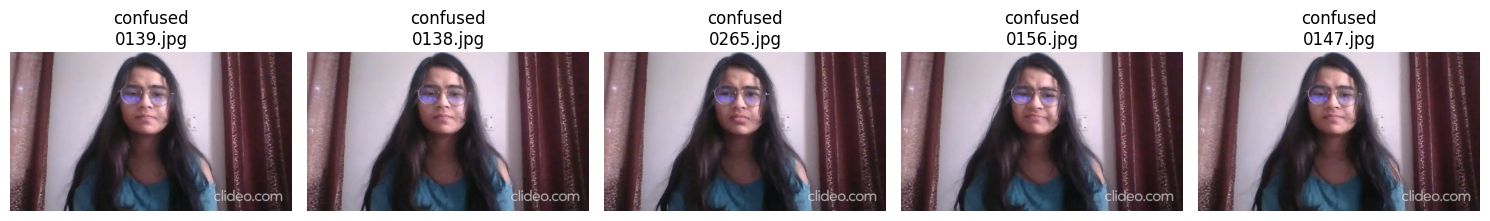

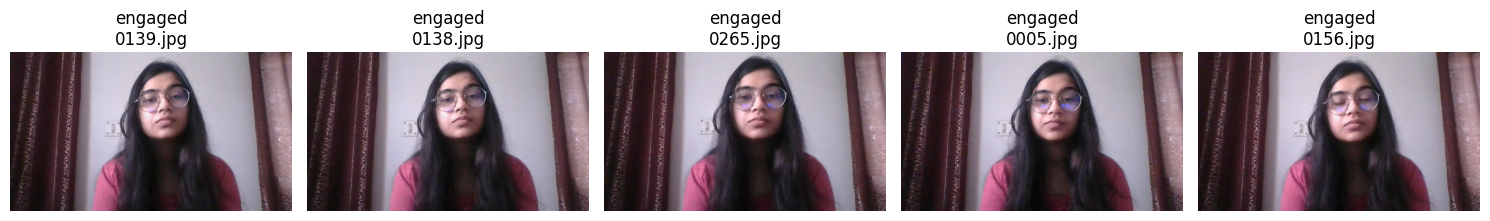

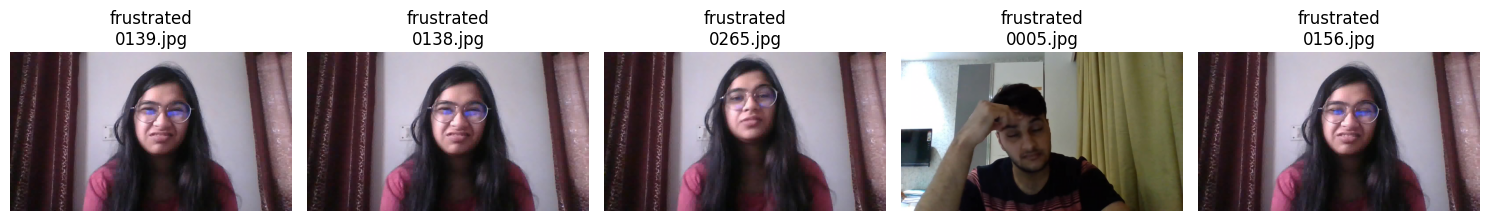

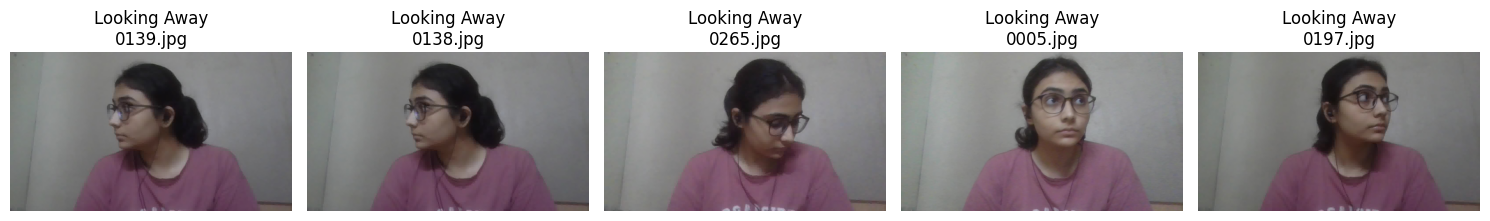

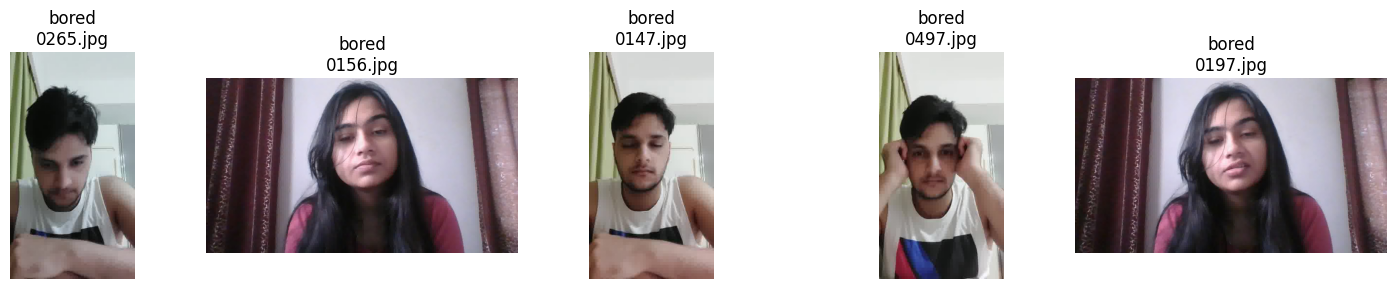

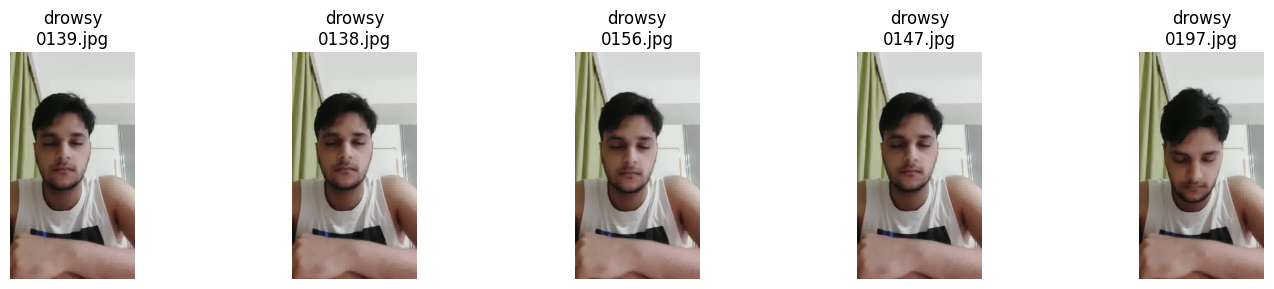

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the path to the dataset folder
student_engagement_folder = 'Student-engagement-dataset'

# Define the categories
engaged_categories = ['confused', 'engaged', 'frustrated']
not_engaged_categories = ['Looking Away', 'bored', 'drowsy']

def plot_images_from_category(category, folder_path, num_images=5):
    category_path = os.path.join(folder_path, category)
    image_files = os.listdir(category_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(category_path, image_file)
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{category}\n{image_file}")
    plt.tight_layout()
    plt.show()

for category in engaged_categories:
    plot_images_from_category(category, os.path.join(student_engagement_folder, 'Engaged'))

for category in not_engaged_categories:
    plot_images_from_category(category, os.path.join(student_engagement_folder, 'Not engaged'))

### Calculating statistics

In [10]:
# Calculate basic statistics
total_images = sum(len(os.listdir(os.path.join(student_engagement_folder, subfolder, category)))
                   for subfolder in ['Engaged', 'Not engaged']
                   for category in os.listdir(os.path.join(student_engagement_folder, subfolder)))

engaged_images = sum(len(os.listdir(os.path.join(student_engagement_folder, 'Engaged', category)))
                     for category in engaged_categories)

not_engaged_images = sum(len(os.listdir(os.path.join(student_engagement_folder, 'Not engaged', category)))
                         for category in not_engaged_categories)

percentage_engaged = (engaged_images / total_images) * 100
percentage_not_engaged = (not_engaged_images / total_images) * 100
avg_images_per_category = total_images / (len(engaged_categories) + len(not_engaged_categories))

# Print the statistics
print("Total number of images:", total_images)
print("Number of engaged images:", engaged_images)
print("Number of not engaged images:", not_engaged_images)
print(f"Percentage of engaged images: {percentage_engaged:.2f}%")
print(f"Percentage of not engaged images: {percentage_not_engaged:.2f}%")
print(f"Average number of images per category: {avg_images_per_category:.2f}")

Total number of images: 2120
Number of engaged images: 1076
Number of not engaged images: 1044
Percentage of engaged images: 50.75%
Percentage of not engaged images: 49.25%
Average number of images per category: 353.33


In [11]:
import os

student_engagement_folder = 'Student-engagement-dataset'
engaged_categories = ['confused', 'engaged', 'frustrated']
not_engaged_categories = ['Looking Away', 'bored', 'drowsy']
all_categories = engaged_categories + not_engaged_categories

category_counts = {}

for subfolder in ['Engaged', 'Not engaged']:
    for category in os.listdir(os.path.join(student_engagement_folder, subfolder)):
        category_path = os.path.join(student_engagement_folder, subfolder, category)
        count = len(os.listdir(category_path))
        category_counts[category] = count

print("Category Counts:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

Category Counts:
frustrated: 360
confused: 369
engaged: 347
bored: 358
Looking Away: 423
drowsy: 263


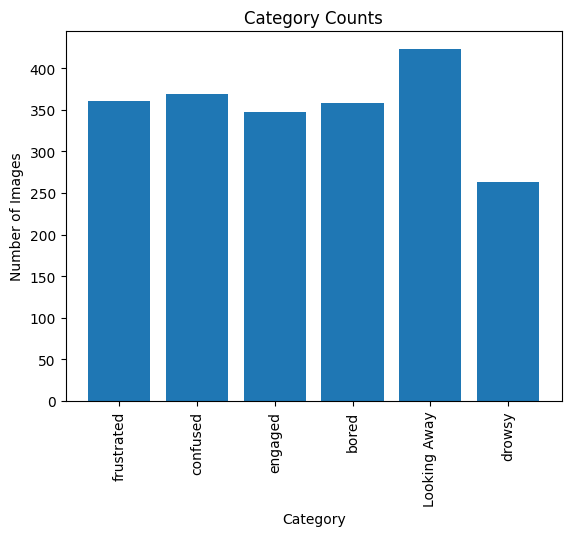

In [12]:
# prompt: category_counts use this to generate histogram

import matplotlib.pyplot as plt

# Create a histogram of the category counts
plt.bar(category_counts.keys(), category_counts.values())
plt.title("Category Counts")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.show()

### Data preprocessing | train/test split | Model Building CNN



### Model 1 : CNN

In [13]:
import os; import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

def load_and_preprocess_images(folder_path, categories, img_size=(64, 64), is_engaged=True):
    data = []
    labels = []
    class_num_offset = 0  # This offset will be used for the "Not engaged" categories

    # If we're loading "Not engaged" categories, the class_num should start after the engaged categories
    if not is_engaged:
        class_num_offset = len(engaged_categories)

    for category in categories:
        category_path = os.path.join(folder_path, category)
        print(f"Loading category: {category}")
        print(f"Category path: {category_path}")

        # Check if the directory exists
        if not os.path.isdir(category_path):
            print(f"Directory does not exist: {category_path}")
            continue

        # Check if the directory is empty
        image_files = os.listdir(category_path)
        if not image_files:
            print(f"Directory is empty: {category_path}")
            continue

        # Debug: Print number of images found
        print(f"Found {len(image_files)} image(s) in category '{category}'.")

        class_num = categories.index(category) + class_num_offset
        for img in image_files:
            try:
                img_path = os.path.join(category_path, img)
                img_arr = mpimg.imread(img_path)
                resized_arr = cv2.resize(img_arr, img_size)
                data.append(resized_arr)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(data), np.array(labels)


# Load "Engaged" and "Not engaged" images
engaged_data, engaged_labels = load_and_preprocess_images(
    os.path.join(student_engagement_folder, 'Engaged'),
    engaged_categories,
    is_engaged=True
)

not_engaged_data, not_engaged_labels = load_and_preprocess_images(
    os.path.join(student_engagement_folder, 'Not engaged'),
    not_engaged_categories,
    is_engaged=False
)

print(f"Engaged data shape: {engaged_data.shape}")
print(f"Not engaged data shape: {not_engaged_data.shape}")

# Combine engaged and not engaged data
X = np.concatenate((engaged_data, not_engaged_data), axis=0)
y = np.concatenate((engaged_labels, not_engaged_labels), axis=0)

# One-hot encode the labels
y = to_categorical(y, num_classes=len(engaged_categories) + len(not_engaged_categories))

# Ensure the data is combined properly
print(f"Combined X shape: {X.shape}")
print(f"Combined y shape: {y.shape}")

# Verify if 'Looking Away', 'bored', 'drowsy' labels exist after combining
print("Labels distribution in combined data:")
unique, counts = np.unique(np.argmax(y, axis=1), return_counts=True)
label_distribution = dict(zip(unique, counts))
for label_index, count in label_distribution.items():
    label_name = (engaged_categories + not_engaged_categories)[label_index]
    print(f"Label '{label_name}': {count} samples")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Add logging to check the distribution of each class in the training and testing datasets
def log_class_distribution(labels, label_names):
    class_counts = np.sum(labels, axis=0)  # Sum columns to get count per class
    for i, count in enumerate(class_counts):
        print(f"Class '{label_names[i]}': {count} samples")

# Log distribution for the training set
print("Class distribution in the training set:")
log_class_distribution(y_train, engaged_categories + not_engaged_categories)

# Log distribution for the testing set
print("\nClass distribution in the testing set:")
log_class_distribution(y_test, engaged_categories + not_engaged_categories)

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.2f}, Test accuracy: {accuracy:.2f}")

Loading category: confused
Category path: Student-engagement-dataset/Engaged/confused
Found 369 image(s) in category 'confused'.
Loading category: engaged
Category path: Student-engagement-dataset/Engaged/engaged
Found 347 image(s) in category 'engaged'.
Loading category: frustrated
Category path: Student-engagement-dataset/Engaged/frustrated
Found 360 image(s) in category 'frustrated'.
Loading category: Looking Away
Category path: Student-engagement-dataset/Not engaged/Looking Away
Found 423 image(s) in category 'Looking Away'.
Loading category: bored
Category path: Student-engagement-dataset/Not engaged/bored
Found 358 image(s) in category 'bored'.
Loading category: drowsy
Category path: Student-engagement-dataset/Not engaged/drowsy
Found 263 image(s) in category 'drowsy'.
Engaged data shape: (1076, 64, 64, 3)
Not engaged data shape: (1044, 64, 64, 3)
Combined X shape: (2120, 64, 64, 3)
Combined y shape: (2120, 6)
Labels distribution in combined data:
Label 'confused': 369 samples
La

In [14]:
X_train.shape, X_test.shape

((1696, 64, 64, 3), (424, 64, 64, 3))

1/1 [==============================] - 0s 307ms/step


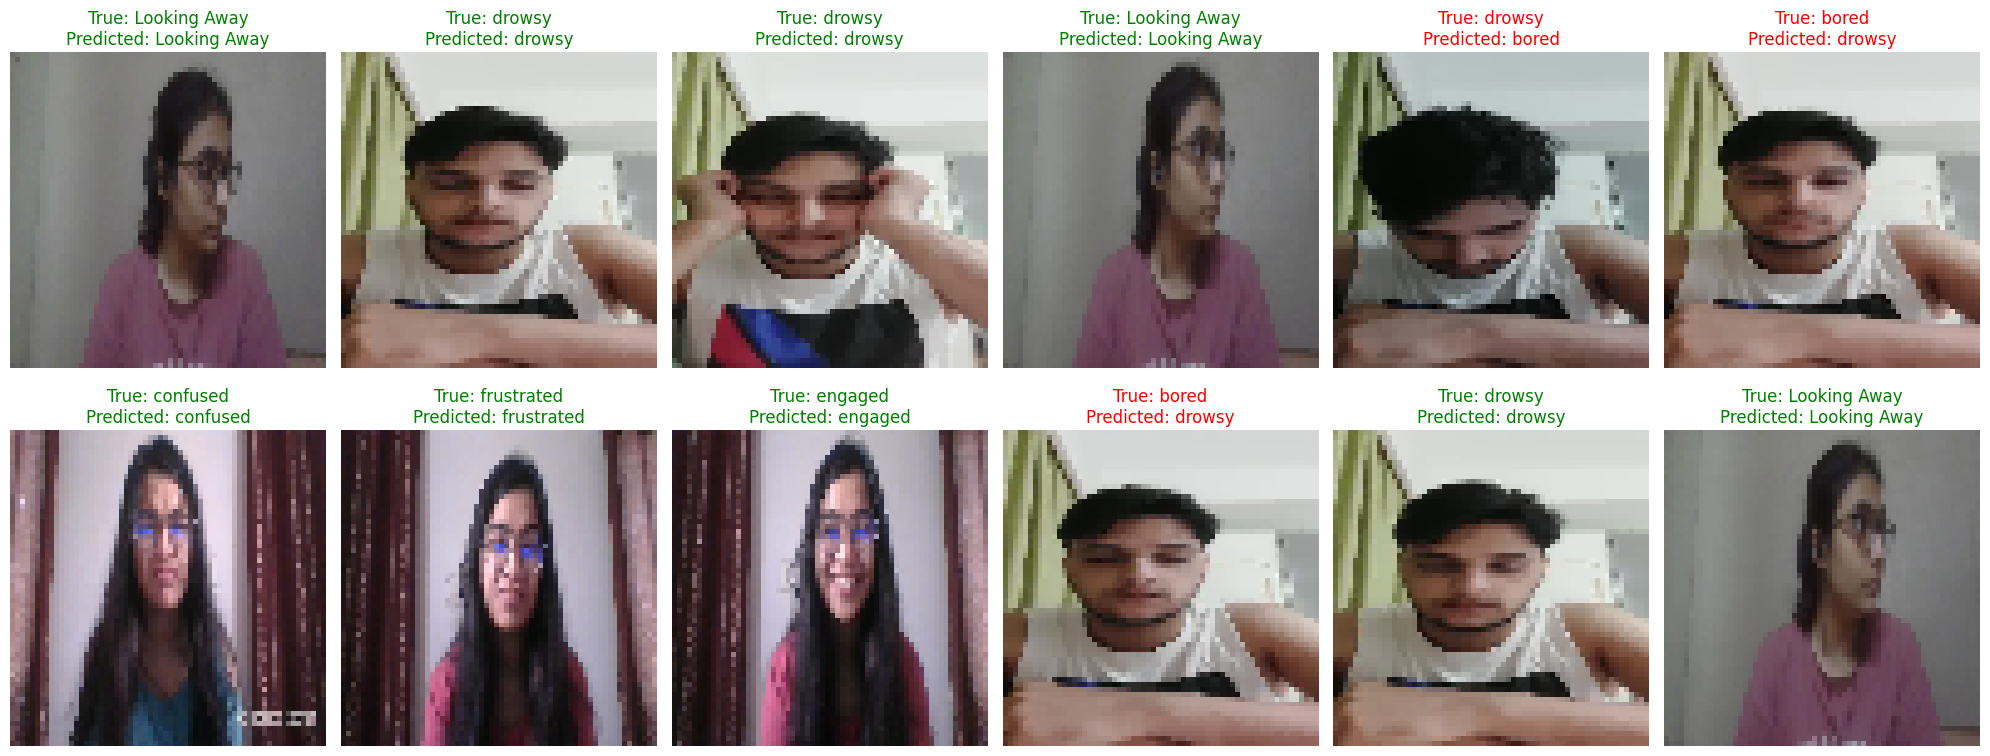

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot images and their predictions in a grid
def plot_predictions(images, true_labels, predictions, max_images_per_row=6):
    num_images = len(images)
    num_rows = (num_images // max_images_per_row) + (1 if num_images % max_images_per_row != 0 else 0)
    fig, axes = plt.subplots(num_rows, min(num_images, max_images_per_row), figsize=(20, 4 * num_rows))
    for i in range(num_images):
        row, col = divmod(i, max_images_per_row)
        if num_rows == 1:  # If there's only one row, axes is a 1D array
            ax = axes[col]
        else:  # If there are multiple rows, axes is a 2D array
            ax = axes[row, col]
        ax.imshow(images[i])
        ax.axis('off')
        true_label = np.argmax(true_labels[i])
        predicted_label = np.argmax(predictions[i])
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"True: {engaged_categories[true_label] if true_label < len(engaged_categories) else not_engaged_categories[true_label - len(engaged_categories)]}\nPredicted: {engaged_categories[predicted_label] if predicted_label < len(engaged_categories) else not_engaged_categories[predicted_label - len(engaged_categories)]}", color=color)
    plt.tight_layout()
    plt.show()

# Make predictions on a subset of the test set
num_samples = 12
sample_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]
predictions = model.predict(sample_images)

# Plot the sample images with their true and predicted labels
plot_predictions(sample_images, sample_labels, predictions)

2/2 [==============================] - 0s 144ms/step


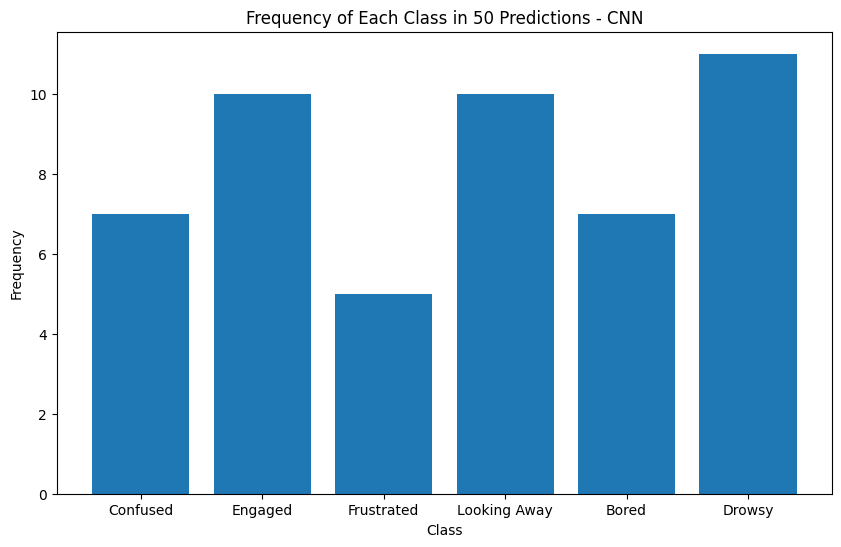

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of test samples to predict
N = 50  # Adjust this value as needed

# Select N random samples from the test set
random_indices = np.random.choice(len(X_test), N, replace=False)
X_test_sample = X_test[random_indices]
y_test_sample = y_test[random_indices]

# Make predictions on the selected test samples
predictions = model.predict(X_test_sample)
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class names
class_names = ['Confused', 'Engaged', 'Frustrated', 'Looking Away', 'Bored', 'Drowsy']
predicted_class_names = [class_names[i] for i in predicted_classes]

# Count the frequency of each class in the predictions
class_counts = {class_name: predicted_class_names.count(class_name) for class_name in class_names}

# Plot the frequency of each class
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title(f'Frequency of Each Class in {N} Predictions - CNN')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Train Loss: 0.0363, Train Accuracy: 0.9817
Test Loss: 0.0425, Test Accuracy: 0.9788


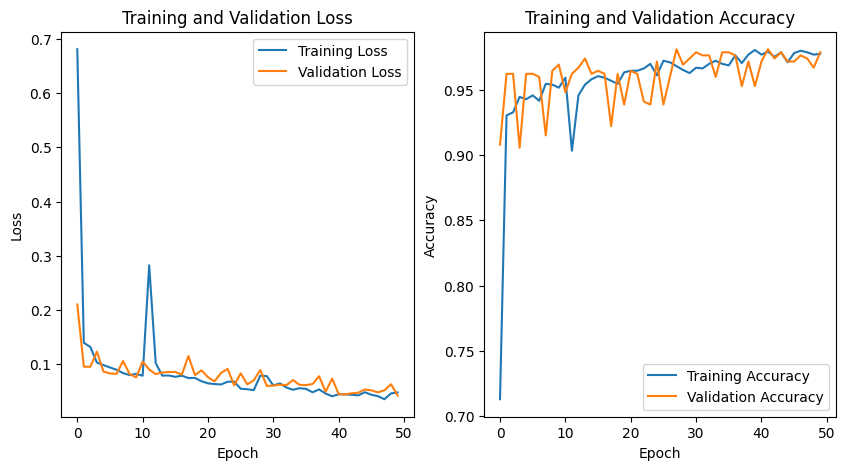

14/14 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

    confused       1.00      1.00      1.00        72
     engaged       1.00      1.00      1.00        74
  frustrated       1.00      0.98      0.99        66
Looking Away       1.00      1.00      1.00        81
       bored       0.91      0.95      0.93        66
      drowsy       0.95      0.92      0.94        65

    accuracy                           0.98       424
   macro avg       0.98      0.98      0.98       424
weighted avg       0.98      0.98      0.98       424



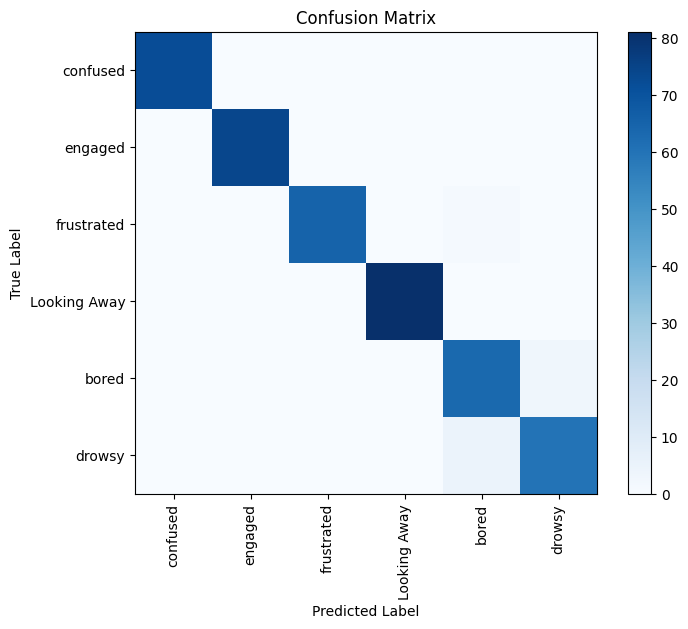

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Visualize training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Combine engaged and not engaged categories
# Get unique classes present in the test set and predictions
unique_classes = np.unique(np.concatenate((y_test_classes, y_pred_classes)))
all_categories = engaged_categories + not_engaged_categories
# Create a mapping from class indices to category names
class_to_category = {i: all_categories[i] for i in unique_classes}

# Print classification report with dynamic target names
print('Classification Report:')
print(classification_report(y_test_classes, y_pred_classes, target_names=[class_to_category[i] for i in unique_classes]))

# Plot confusion matrix with dynamic labels
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes], rotation=90)
plt.yticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model 2 : Transfer Learning (VGG16)

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze the base model

model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_tl = model_tl.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/50
53/53 [==============================] - 7s 54ms/step - loss: 0.7198 - accuracy: 0.7111 - val_loss: 0.3395 - val_accuracy: 0.8774
Epoch 2/50
53/53 [==============================] - 2s 29ms/step - loss: 0.2878 - accuracy: 0.9310 - val_loss: 0.1942 - val_accuracy: 0.9623
Epoch 3/50
53/53 [==============================] - 1s 19ms/step - loss: 0.1790 - accuracy: 0.9463 - val_loss: 0.1514 - val_accuracy: 0.9528
Epoch 4/50
53/53 [==============================] - 1s 21ms/step - loss: 0.1376 - accuracy: 0.9469 - val_loss: 0.1209 - val_accuracy: 0.9623
Epoch 5/50
53/53 [==============================] - 1s 19ms/step - loss: 0.1140 - accuracy: 0.9528 - val_loss: 0.0986 - val_accuracy: 0.9646
Epoch 6/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0986 - accuracy: 0.9558 - val_loss: 0.0902 - val_accuracy: 0.9670
Epoch 7/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0943 - accurac

14/14 [==============================] - 0s 15ms/step - loss: 0.0681 - accuracy: 0.9741
Test loss: 0.07, Test accuracy: 0.97


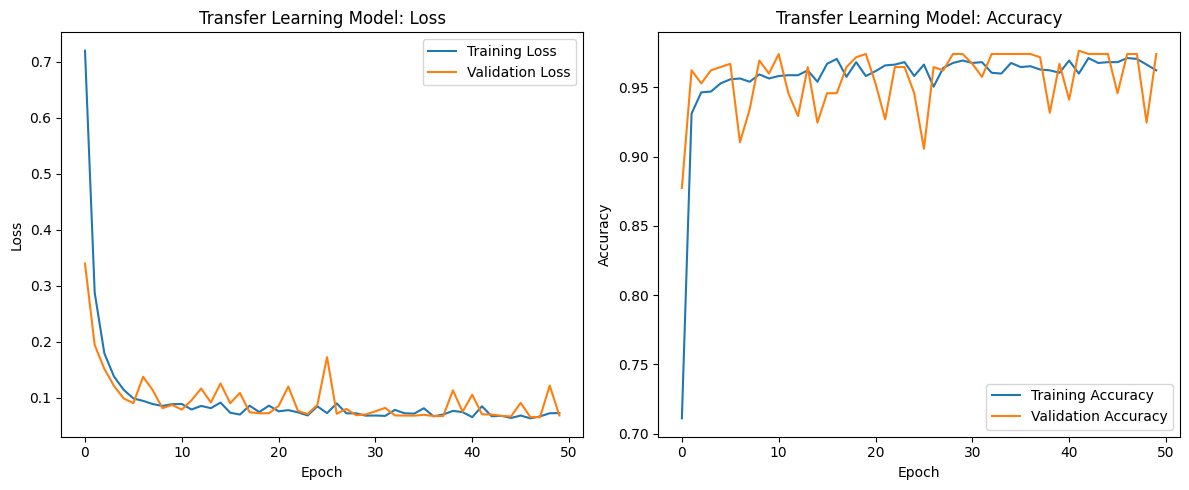

14/14 [==============================] - 0s 13ms/step


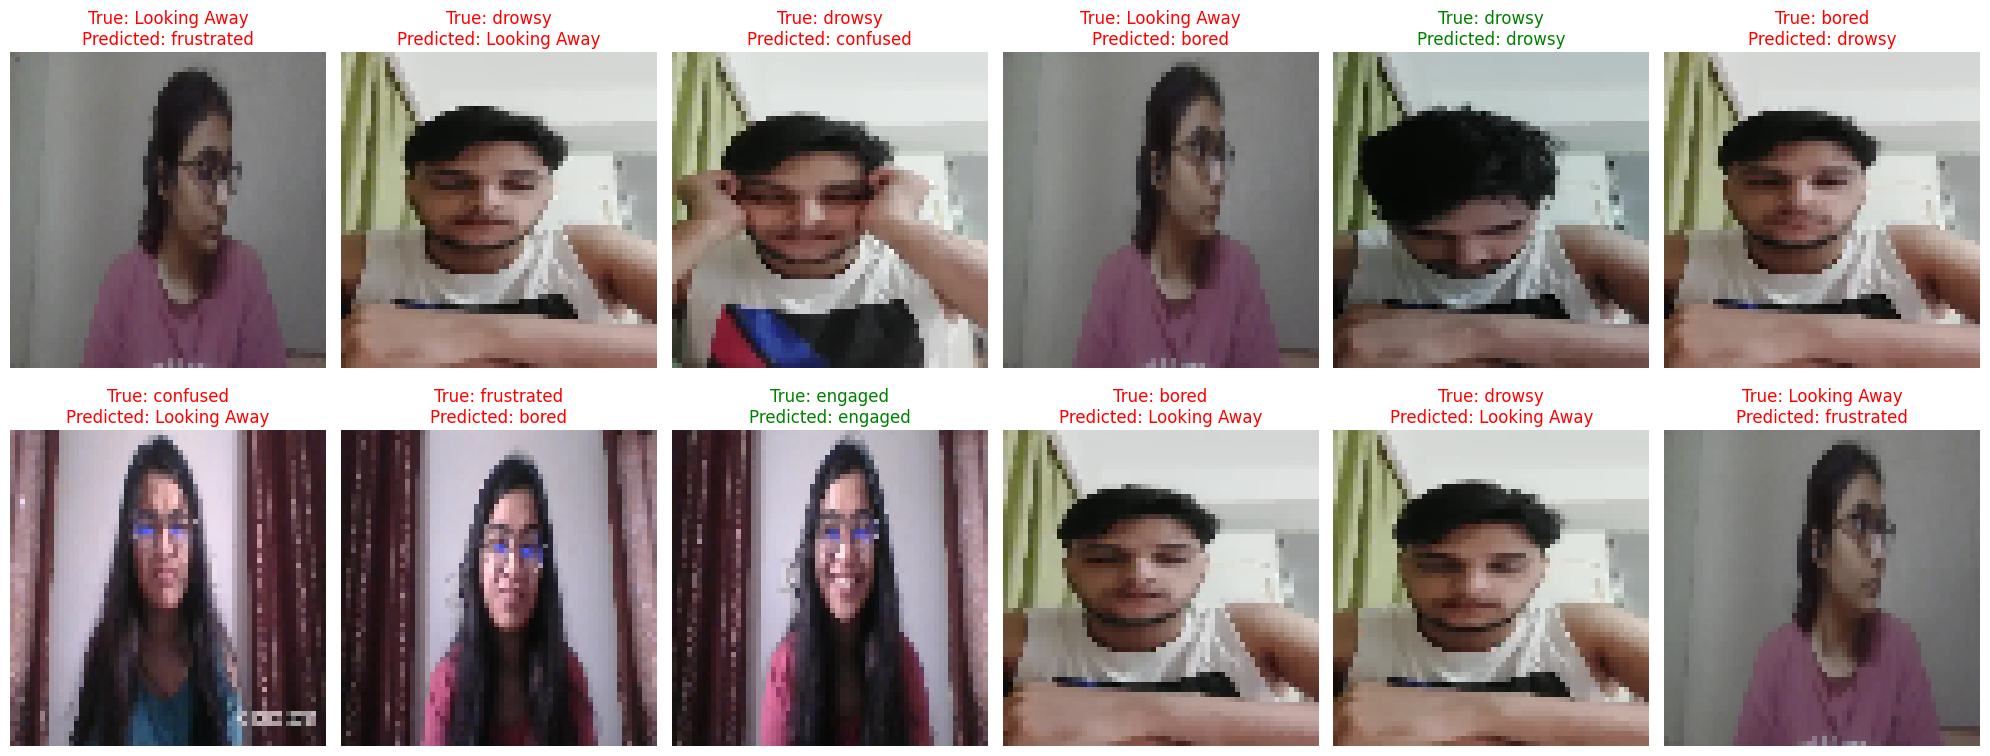

In [19]:
import matplotlib.pyplot as plt

# Evaluate the transfer learning model
tl_loss, tl_accuracy = model_tl.evaluate(X_test, y_test)
print(f"Test loss: {tl_loss:.2f}, Test accuracy: {tl_accuracy:.2f}")

# Visualize the training history
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(hist_tl.history['loss'], label='Training Loss')
plt.plot(hist_tl.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_tl.history['accuracy'], label='Training Accuracy')
plt.plot(hist_tl.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions using the transfer learning model
tl_predictions = model_tl.predict(X_test)

# Plot the sample images with their true and predicted labels using the transfer learning model
plot_predictions(sample_images, sample_labels, tl_predictions)

### Model 3 : EfficientNetB0

In [20]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout

# Advanced DL architecture using EfficientNetB0
def create_efficientnet_model(input_shape=(64, 64, 3), num_classes=6):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet_model = create_efficientnet_model()
efficientnet_hist = efficientnet_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/50
53/53 [==============================] - 15s 99ms/step - loss: 2.5456 - accuracy: 0.2370 - val_loss: 1.9049 - val_accuracy: 0.1910
Epoch 2/50
53/53 [==============================] - 1s 14ms/step - loss: 2.2343 - accuracy: 0.3031 - val_loss: 1.7835 - val_accuracy: 0.1910
Epoch 3/50
53/53 [==============================] - 1s 13ms/step - loss: 1.9098 - accuracy: 0.3762 - val_loss: 1.7279 - val_accuracy: 0.3656
Epoch 4/50
53/53 [==============================] - 1s 13ms/step - loss: 1.8311 - accuracy: 0.3939 - val_loss: 1.6581 - val_accuracy: 0.3656
Epoch 5/50
53/53 [==============================] - 1s 13ms/step - loss: 1.7085 - accuracy: 0.4021 - val_loss: 1.6553 - val_accuracy: 0.2524
Epoch 6/50
53/53 [==============================] - 1s 13ms/step - loss: 1.5497 - accuracy: 0.4334 - val_loss: 1.6121 - val_accuracy: 0.3656
Epoch 7/50
53/53 [==============================] - 1s 17ms/step - loss: 1.4863 - accura

14/14 [==============================] - 0s 18ms/step - loss: 0.9686 - accuracy: 0.5991
EfficientNet - Test Loss: 0.97, Test Accuracy: 0.60


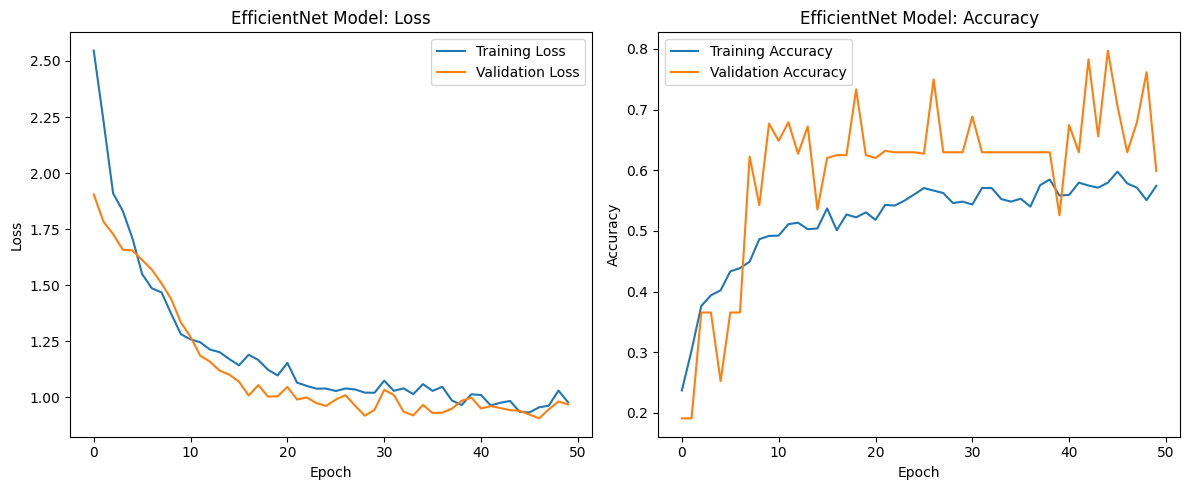

14/14 [==============================] - 4s 14ms/step


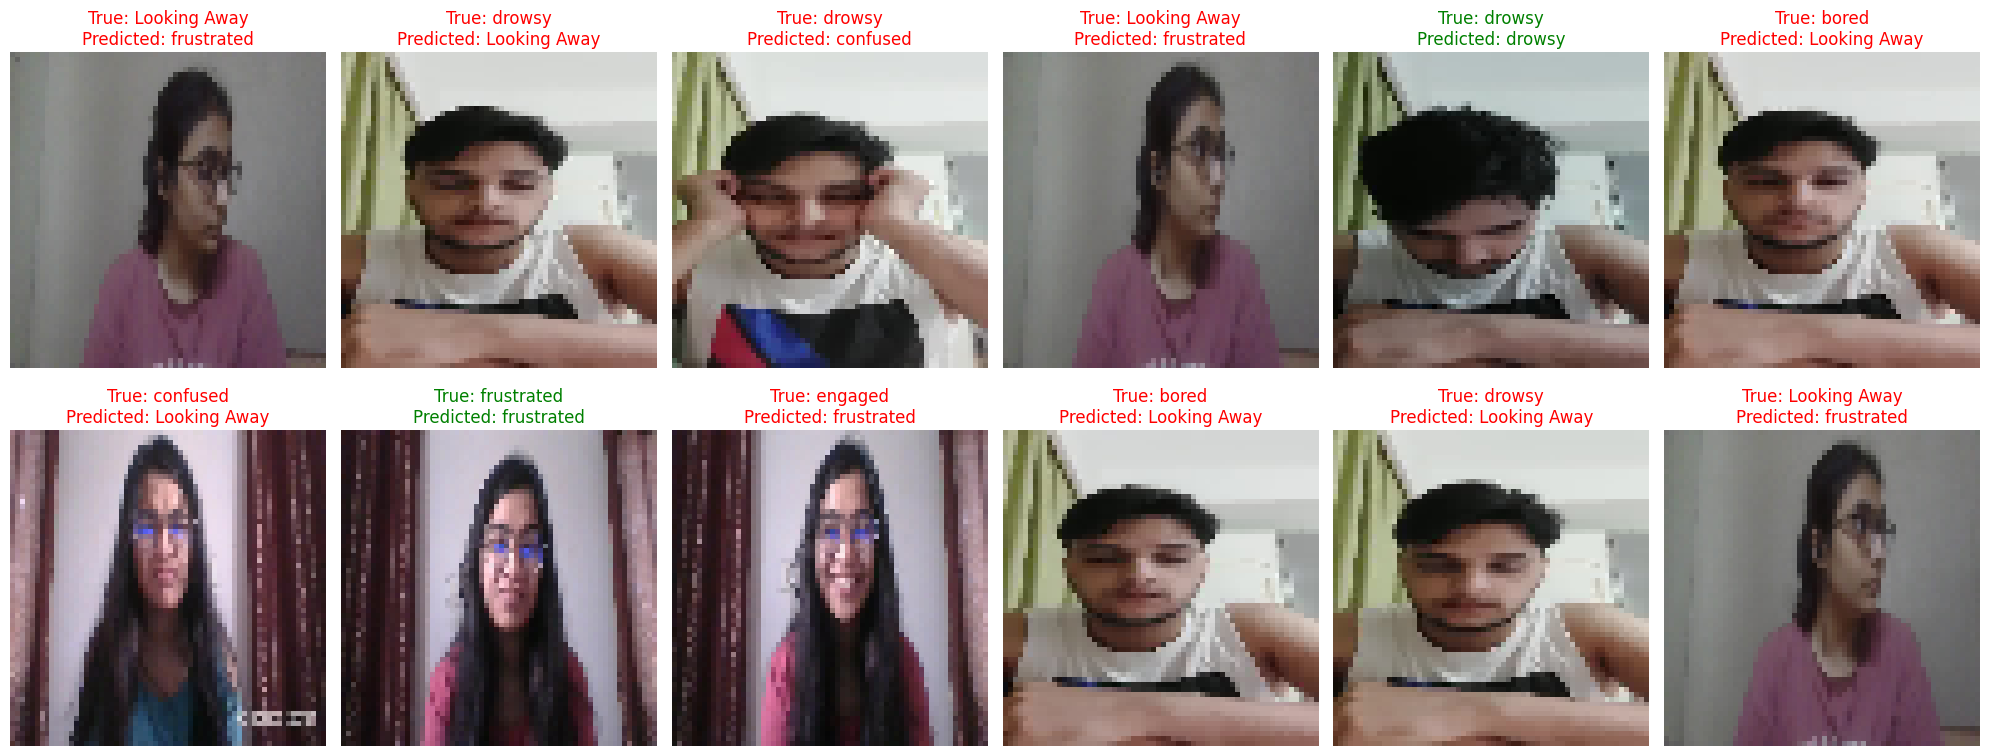

In [21]:
# Evaluate the EfficientNet model
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(X_test, y_test)
print(f"EfficientNet - Test Loss: {efficientnet_loss:.2f}, Test Accuracy: {efficientnet_accuracy:.2f}")

# Visualize the training history for EfficientNet
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(efficientnet_hist.history['loss'], label='Training Loss')
plt.plot(efficientnet_hist.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(efficientnet_hist.history['accuracy'], label='Training Accuracy')
plt.plot(efficientnet_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions using the EfficientNet model
efficientnet_predictions = efficientnet_model.predict(X_test)

# Plot the sample images with their true and predicted labels using the EfficientNet model
plot_predictions(sample_images, sample_labels, efficientnet_predictions)

14/14 [==============================] - 0s 13ms/step


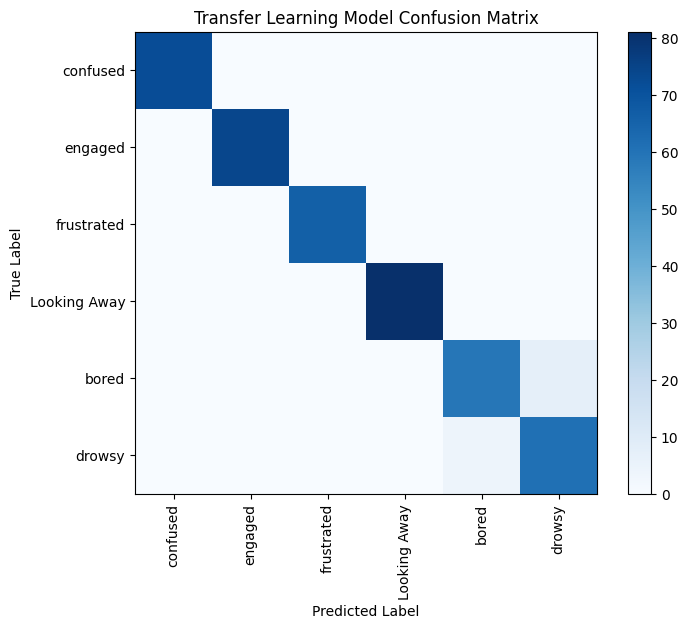

14/14 [==============================] - 0s 11ms/step


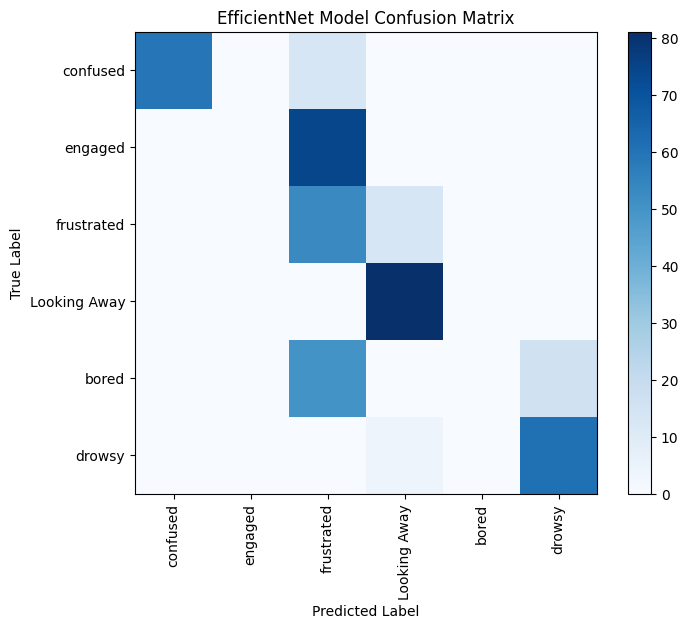

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Transfer Learning Model Confusion Matrix
tl_y_pred = model_tl.predict(X_test)
tl_y_pred_classes = np.argmax(tl_y_pred, axis=1)
tl_y_test_classes = np.argmax(y_test, axis=1)

tl_cm = confusion_matrix(tl_y_test_classes, tl_y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(tl_cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes], rotation=90)
plt.yticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Transfer Learning Model Confusion Matrix')
plt.show()

# EfficientNet Model Confusion Matrix
efficientnet_y_pred = efficientnet_model.predict(X_test)
efficientnet_y_pred_classes = np.argmax(efficientnet_y_pred, axis=1)
efficientnet_y_test_classes = np.argmax(y_test, axis=1)

efficientnet_cm = confusion_matrix(efficientnet_y_test_classes, efficientnet_y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(efficientnet_cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes], rotation=90)
plt.yticks(np.arange(len(unique_classes)), [class_to_category[i] for i in unique_classes])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('EfficientNet Model Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
# Define evaluation parameters for each model
model_evaluation = {
    'Model': ['CNN', 'Transfer Learning (VGG16)', 'EfficientNetB0'],
    'Test Accuracy': [accuracy, tl_accuracy, efficientnet_accuracy],
    'Test Loss': [loss, tl_loss, efficientnet_loss]
}

# Calculate precision, recall, and f1 score for CNN
cnn_precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
cnn_recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
cnn_f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Calculate precision, recall, and f1 score for Transfer Learning model
tl_precision = precision_score(tl_y_test_classes, tl_y_pred_classes, average='weighted')
tl_recall = recall_score(tl_y_test_classes, tl_y_pred_classes, average='weighted')
tl_f1 = f1_score(tl_y_test_classes, tl_y_pred_classes, average='weighted')

# Calculate precision, recall, and f1 score for EfficientNet
efficientnet_precision = precision_score(efficientnet_y_test_classes, efficientnet_y_pred_classes, average='weighted')
efficientnet_recall = recall_score(efficientnet_y_test_classes, efficientnet_y_pred_classes, average='weighted')
efficientnet_f1 = f1_score(efficientnet_y_test_classes, efficientnet_y_pred_classes, average='weighted')

# Update the model comparison DataFrame with the new metrics
model_evaluation.update({
    'Precision': [cnn_precision, tl_precision, efficientnet_precision],
    'Recall': [cnn_recall, tl_recall, efficientnet_recall],
    'F1 Score': [cnn_f1, tl_f1, efficientnet_f1]
})

model_comparison_df = pd.DataFrame(model_evaluation)

# Display the updated comparison table
model_comparison_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Test Accuracy  Test Loss  Precision    Recall  \
0                        CNN       0.978774   0.042475   0.979164  0.978774   
1  Transfer Learning (VGG16)       0.974057   0.068110   0.974336  0.974057   
2             EfficientNetB0       0.599057   0.968554   0.492578  0.599057   

   F1 Score  
0  0.978853  
1  0.974048  
2  0.522017

4/4 [==============================] - 1s 255ms/step


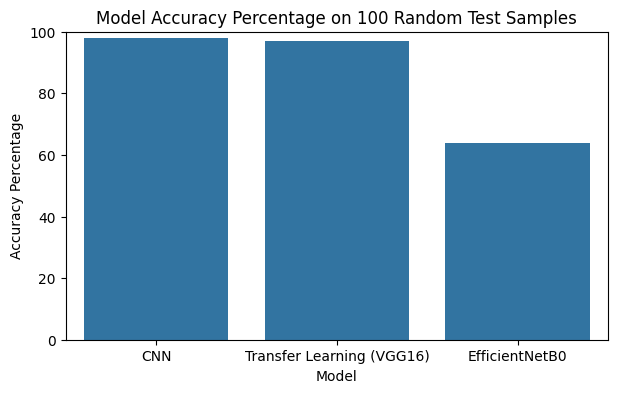

In [24]:


# Function to calculate the percentage of correct predictions
def calculate_accuracy(model, X_test, y_test, num_samples=100):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    X_test_sample = X_test[sample_indices]
    y_test_sample = y_test[sample_indices]
    y_pred = model.predict(X_test_sample)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_sample, axis=1)
    correct_predictions = np.sum(y_pred_classes == y_test_classes)
    accuracy_percentage = (correct_predictions / num_samples) * 100
    return accuracy_percentage

# Calculate accuracy percentage for each model on 100 samples
cnn_accuracy_percentage = calculate_accuracy(model, X_test, y_test)
tl_accuracy_percentage = calculate_accuracy(model_tl, X_test, y_test)
efficientnet_accuracy_percentage = calculate_accuracy(efficientnet_model, X_test, y_test)

# Create a DataFrame for plotting
accuracy_data = {
    'Model': ['CNN', 'Transfer Learning (VGG16)', 'EfficientNetB0'],
    'Accuracy Percentage': [cnn_accuracy_percentage, tl_accuracy_percentage, efficientnet_accuracy_percentage]
}
accuracy_df = pd.DataFrame(accuracy_data)

# Plot the comparison
plt.figure(figsize=(7, 4))
sns.barplot(x='Model', y='Accuracy Percentage', data=accuracy_df)
plt.title('Model Accuracy Percentage on 100 Random Test Samples')
plt.ylim(0, 100)
plt.ylabel('Accuracy Percentage')
plt.xlabel('Model')
plt.show()

In [25]:
# Select 10 random samples for demonstration
num_samples = 10
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

# Make predictions with each model
cnn_predictions = model.predict(X_test_sample)
tl_predictions = model_tl.predict(X_test_sample)
efficientnet_predictions = efficientnet_model.predict(X_test_sample)

# Convert predictions to class indices
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
tl_pred_classes = np.argmax(tl_predictions, axis=1)
efficientnet_pred_classes = np.argmax(efficientnet_predictions, axis=1)
true_classes = np.argmax(y_test_sample, axis=1)

# Create a DataFrame to hold the predictions
predictions_df = pd.DataFrame({
    'True Label': [class_names[i] for i in true_classes],
    'CNN': [class_names[i] for i in cnn_pred_classes],
    'Transfer Learning (VGG16)': [class_names[i] for i in tl_pred_classes],
    'EfficientNetB0': [class_names[i] for i in efficientnet_pred_classes]
})

predictions_df

1/1 [==============================] - 1s 794ms/step


True Label         CNN Transfer Learning (VGG16) EfficientNetB0
0  Frustrated  Frustrated                Frustrated   Looking Away
1       Bored       Bored                     Bored     Frustrated
2     Engaged     Engaged                   Engaged     Frustrated
3     Engaged     Engaged                   Engaged     Frustrated
4  Frustrated  Frustrated                Frustrated   Looking Away
5       Bored       Bored                     Bored     Frustrated
6     Engaged     Engaged                   Engaged     Frustrated
7       Bored       Bored                     Bored     Frustrated
8      Drowsy      Drowsy                    Drowsy         Drowsy
9      Drowsy      Drowsy                    Drowsy         Drowsy

### Model 4 : ResNet Model using Transfer learning

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the ResNet model using transfer learning
def create_resnet_model(input_shape=(64, 64, 3), num_classes=6):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
resnet_model = create_resnet_model()

# Train the model
history_resnet = resnet_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test, y_test)
print(f"ResNet Model - Test Loss: {resnet_loss:.2f}, Test Accuracy: {resnet_accuracy:.2f}")

# Add the model to the comparison
model_evaluation['Model'].append('ResNet50')
model_evaluation['Test Accuracy'].append(resnet_accuracy)
model_evaluation['Test Loss'].append(resnet_loss)

# Calculate precision, recall, and f1 score for ResNet
resnet_y_pred = resnet_model.predict(X_test)
resnet_y_pred_classes = np.argmax(resnet_y_pred, axis=1)
resnet_precision = precision_score(y_test_classes, resnet_y_pred_classes, average='weighted')
resnet_recall = recall_score(y_test_classes, resnet_y_pred_classes, average='weighted')
resnet_f1 = f1_score(y_test_classes, resnet_y_pred_classes, average='weighted')

model_evaluation['Precision'].append(resnet_precision)
model_evaluation['Recall'].append(resnet_recall)
model_evaluation['F1 Score'].append(resnet_f1)

# Update and display the DataFrame
model_comparison_df = pd.DataFrame(model_evaluation)
model_comparison_df

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
53/53 [==============================] - 7s 54ms/step - loss: 0.9716 - accuracy: 0.6409 - val_loss: 0.6076 - val_accuracy: 0.8184
Epoch 2/50
53/53 [==============================] - 1s 24ms/step - loss: 0.5043 - accuracy: 0.8449 - val_loss: 0.4163 - val_accuracy: 0.8538
Epoch 3/50
53/53 [==============================] - 1s 20ms/step - loss: 0.3674 - accuracy: 0.8939 - val_loss: 0.3352 - val_accuracy: 0.8821
Epoch 4/50
53/53 [==============================] - 1s 20ms/step - loss: 0.3085 - accuracy: 0.8950 - val_loss: 0.2553 - val_accuracy: 0.9316
Epoch 5/50
53/53 [==============================] - 1s 21ms/step - loss: 0.2414 - accuracy: 0.9104 - val_loss: 0.2228 - val_accuracy: 0.9458
Epoch 6/50
53/53 [==============================] - 1s 20ms/step - loss: 0.2202 - accuracy: 0.9198 - val_loss: 0.1931 - val_accuracy: 0.9434
Epoch 7/50
53/53 [==============================] - 1s 18ms/step - loss: 0.1983 - accurac

Model  Test Accuracy  Test Loss  Precision    Recall  \
0                        CNN       0.978774   0.042475   0.979164  0.978774   
1  Transfer Learning (VGG16)       0.974057   0.068110   0.974336  0.974057   
2             EfficientNetB0       0.599057   0.968554   0.492578  0.599057   
3                   ResNet50       0.966981   0.082170   0.972833  0.966981   

   F1 Score  
0  0.978853  
1  0.974048  
2  0.522017  
3  0.966627

In [ ]:
!pip install accelerate>=0.21.0 -U

In [ ]:
import accelerate
print("Accelerate version:", accelerate.__version__)

In [ ]:
!pip install transformers[torch] -U

In [ ]:
import transformers
import accelerate
print(transformers.__version__)
print(accelerate.__version__)

 ### Model 5 : ViT For Image Classification (Hugging face model)

In [32]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.model_selection import train_test_split
from PIL import Image

# Set the path to the dataset folder
student_engagement_folder = 'Student-engagement-dataset'

# Define the categories
engaged_categories = ['confused', 'engaged', 'frustrated']
not_engaged_categories = ['Looking Away', 'bored', 'drowsy']
all_categories = engaged_categories + not_engaged_categories

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_images_and_labels(categories, folder_path, is_engaged=True):
    images = []
    labels = []
    class_num_offset = 0 if is_engaged else len(engaged_categories)
    for category in categories:
        category_path = os.path.join(folder_path, category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            images.append(img_path)
            labels.append(class_num_offset + categories.index(category))
    return images, labels

# Load images and labels
engaged_images, engaged_labels = load_images_and_labels(
    engaged_categories, os.path.join(student_engagement_folder, 'Engaged'), is_engaged=True)
not_engaged_images, not_engaged_labels = load_images_and_labels(
    not_engaged_categories, os.path.join(student_engagement_folder, 'Not engaged'), is_engaged=False)

all_images = engaged_images + not_engaged_images
all_labels = engaged_labels + not_engaged_labels

# Split data into train and test
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Preprocessing transformations using ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

train_transform = transforms.Compose([
    lambda x: feature_extractor(x, return_tensors='pt')['pixel_values'].squeeze(0)
])

test_transform = transforms.Compose([
    lambda x: feature_extractor(x, return_tensors='pt')['pixel_values'].squeeze(0)
])

# Create train and test datasets
train_dataset = CustomImageDataset(train_images, train_labels, transform=train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained Vision Transformer model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(all_categories), ignore_mismatched_sizes=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(2):  # Let's train for only 5 epochs for demonstration
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Print loss every 10 batches (or fewer if less than 10 batches total)
        if (batch_idx + 1) % max(1, total_batches // 1) == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}, Batch Loss: {loss.item():.4f}")

    average_loss = running_loss / total_batches
    print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")


# Evaluation
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Batch 53/53, Batch Loss: 0.2162
Epoch 1, Average Loss: 0.2231
Epoch 2, Batch 53/53, Batch Loss: 0.0846
Epoch 2, Average Loss: 0.0827


In [33]:
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")
print(f"Correct: {correct}/{total}")

Accuracy: 97.88%
Correct: 415/424


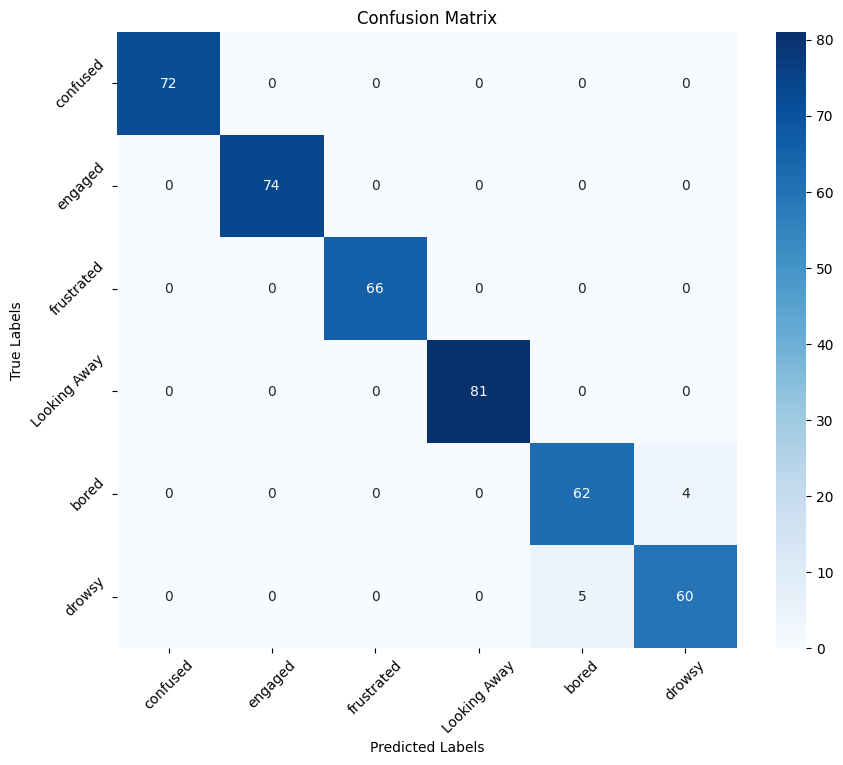

In [36]:
# Prepare to collect all labels and predictions
all_labels = []
all_preds = []

# Evaluate the model
with torch.no_grad():
    for images, labels in test_loader:  # Assuming each batch is a tuple of (images, labels)
        images = images.to(device)      # Move images to the appropriate device
        labels = labels.to(device)      # Move labels to the appropriate device
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        all_preds.extend(predicted.cpu().numpy())  # Store predictions

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = all_categories  # Ensure 'all_categories' contains your class names

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Models Comparison

In [39]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate accuracy
vit_accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and f1 score
vit_precision = precision_score(all_labels, all_preds, average='weighted')
vit_recall = recall_score(all_labels, all_preds, average='weighted')
vit_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print ViT model metrics for clarity
print(f"ViT Model - Test Accuracy: {vit_accuracy:.2f}")
print(f"ViT Model - Precision: {vit_precision:.2f}")
print(f"ViT Model - Recall: {vit_recall:.2f}")
print(f"ViT Model - F1 Score: {vit_f1:.2f}")
# Add the ViT model to the comparison
model_evaluation['Model'].append('ViT')
model_evaluation['Test Accuracy'].append(vit_accuracy)
model_evaluation['Test Loss'].append(None)  # Assuming loss was not directly calculated during evaluation

# Adding precision, recall, and F1 score
model_evaluation['Precision'].append(vit_precision)
model_evaluation['Recall'].append(vit_recall)
model_evaluation['F1 Score'].append(vit_f1)

# Convert to DataFrame and display the updated comparison table
model_comparison_df = pd.DataFrame(model_evaluation)
model_comparison_df

ViT Model - Test Accuracy: 0.98
ViT Model - Precision: 0.98
ViT Model - Recall: 0.98
ViT Model - F1 Score: 0.98


Model  Test Accuracy  Test Loss  Precision    Recall  \
0                        CNN       0.978774   0.042475   0.979164  0.978774   
1  Transfer Learning (VGG16)       0.974057   0.068110   0.974336  0.974057   
2             EfficientNetB0       0.599057   0.968554   0.492578  0.599057   
3                   ResNet50       0.966981   0.082170   0.972833  0.966981   
4                        ViT       0.978774        NaN   0.978802  0.978774   
5                        ViT       0.978774        NaN   0.978802  0.978774   

   F1 Score  
0  0.978853  
1  0.974048  
2  0.522017  
3  0.966627  
4  0.978771  
5  0.978771

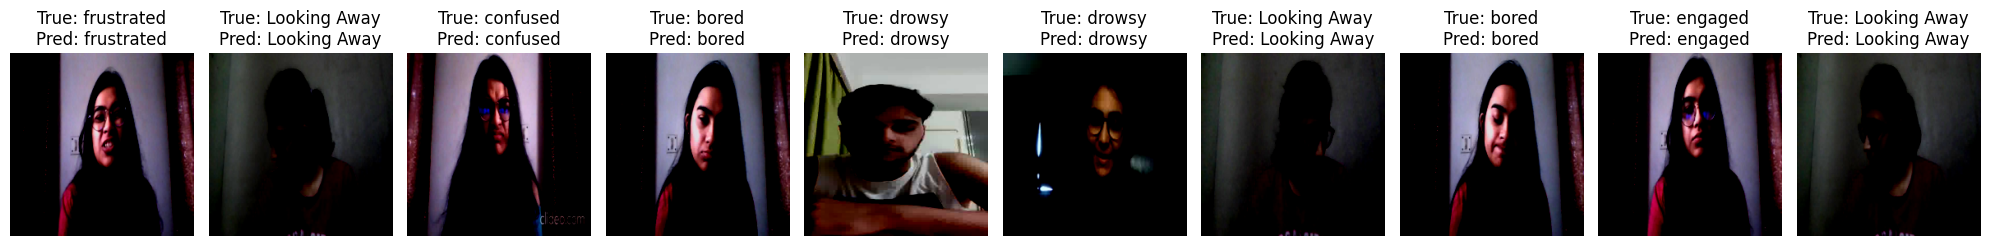

In [43]:
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

model.eval()  # Set model to evaluation mode

# Choose a number of samples to display
num_samples = 10
sample_images = []
sample_labels = []
sample_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        # Collect samples
        sample_images.extend(images.cpu().numpy())
        sample_labels.extend(labels.cpu().numpy())
        sample_preds.extend(preds.cpu().numpy())

        if len(sample_images) >= num_samples:
            break

sample_images = np.array(sample_images[:num_samples])
sample_labels = np.array(sample_labels[:num_samples])
sample_preds = np.array(sample_preds[:num_samples])

import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, predicted_labels, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, true_label, pred_label) in enumerate(zip(images, true_labels, predicted_labels)):
        ax = axes[i]
        img = img.transpose(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C) for plotting
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")

    plt.tight_layout()
    plt.show()

plot_predictions(sample_images, sample_labels, sample_preds, all_categories)